<a href="https://colab.research.google.com/github/Pavi-NP/FacialEmotionYOLOVisionToAudio/blob/main/image2audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Install necessary libraries


Note: opencv-python-headless is used since GUI functions don't work in Colab.

In [ ]:
!pip install ultralytics deepface gtts opencv-python-headless numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00


##Import libraries and set up

In [ ]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from gtts import gTTS
from IPython.display import Audio, display
from ultralytics import YOLO
from deepface import DeepFace
import warnings
warnings.filterwarnings('ignore')

25-09-12 11:25:08 - Directory /root/.deepface has been created
25-09-12 11:25:08 - Directory /root/.deepface/weights has been created


##Upload your image
Images from:
https://stock.adobe.com/search?k=multiple+face+emotions

In [ ]:
from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print(f"Loaded image: {image_path}")

Saving face6.jpeg to face6.jpeg
Loaded image: face6.jpeg


## Display the image

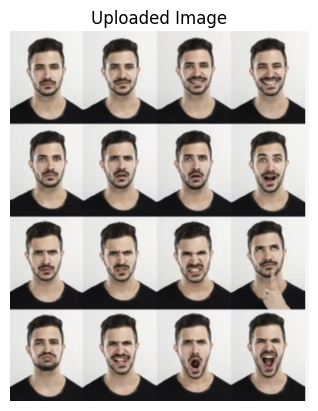

In [ ]:
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Uploaded Image')
plt.show()

##Load YOLOv8 model

In [ ]:
model = YOLO('yolov8n.pt')  # will auto-download if not present

## Define detection and emotion functions

In [ ]:
def detect_people(image):
    results = model(image)
    boxes_list = []
    for r in results:
        for box in r.boxes:
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            if class_id == 0 and confidence > 0.5:
                xyxy = box.xyxy[0].cpu().numpy()
                boxes_list.append(xyxy)
    return boxes_list

def detect_faces_emotions(person_roi):
    try:
        results = DeepFace.analyze(person_roi, actions=['emotion'], enforce_detection=False)
        if isinstance(results, list):
            return [res['dominant_emotion'] for res in results]
        else:
            return [results['dominant_emotion']]
    except Exception as e:
        print(f"Emotion detection error: {e}")
        return []

def analyze_image(image_path):
    image = cv2.imread(image_path)
    person_boxes = detect_people(image)
    person_count = len(person_boxes)
    emotion_counts = {}

    for box in person_boxes:
        x1, y1, x2, y2 = map(int, box)
        # Ensure coordinates are within image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image.shape[1], x2), min(image.shape[0], y2)
        person_roi = image[y1:y2, x1:x2]
        if person_roi.size == 0:
            continue
        emotions = detect_faces_emotions(person_roi)
        for emotion in emotions:
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1

    # Build description
    if person_count > 0:
        desc = f"I detected {person_count} person{'s' if person_count > 1 else ''}. "
        if emotion_counts:
            desc += "Facial expressions include: "
            desc += ', '.join([f"{count} {emotion.lower()}" for emotion, count in emotion_counts.items()])
        else:
            desc += "But I couldn't clearly detect facial expressions."
    else:
        desc = "I couldn't detect any people in this image."
    return desc

## Generate and display audio

In [ ]:
def play_text_audio(text):
    tts = gTTS(text=text, lang='en')
    filename = "description.mp3"
    tts.save(filename)
    display(Audio(filename))

## Run the analysis and show results

In [ ]:
description = analyze_image(image_path)
print(description)
print("Playing audio...")
play_text_audio(description)


0: 640x544 16 persons, 204.3ms
Speed: 4.6ms preprocess, 204.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 544)
I detected 16 persons. Facial expressions include: 7 neutral, 3 angry, 2 sad, 4 happy, 1 fear
Playing audio...
